# Bloch-Redfield Solver: Two Level System

Author: C.Staufenbiel, 2022

with inspirations from the [`brmesolve notebook`](https://github.com/qutip/qutip-notebooks/blob/master/examples/brmesolve.ipynb) by P.D. Nation.


### Introduction

The Bloch-Redfield solver is another method to solve a master equation. In comparison to the Lindblad Master equation solver `qutip.mesolve()` the Bloch-Redfield solver `qutip.brmesolve()` differs in the description of the interaction with the environment. In `qutip.mesolve()` we described the dissipation by collapse operators, which do not necessarily have a physical interpretation. The `qutip.brmesolve()` function requires the a dissipation description by the so-called *noise-power-spectrum*, which gives the intensity of the dissipation depending on the frequency $\omega$.

In this notebook we will introduce the basic usage of `qutip.brmesolve()` and compare it to `qutip.mesolve()`. For more information on the Bloch-Redfield solver see the follow-up notebooks and the [QuTiP Documentation of the functionality](https://qutip.org/docs/latest/guide/dynamics/dynamics-bloch-redfield.html).

### Imports

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
from qutip import *

%matplotlib inline

In [33]:
def expo(x,A,b):
    return A*np.exp(x*b)

## Two-level system evolution

In this example we consider a simple two level system described by the Hamiltonian:

$$ H = \frac{\epsilon}{2} \sigma_z$$

Furthermore, we define a constant dissipation rate to the environment $\gamma$.

Can compare to Hamiltonian shown by Petros

$$ 
H = \frac{\hbar}{2}
\begin{pmatrix}
0 & \Omega \\
\Omega & -\Delta
\end{pmatrix}
$$

Where $\Omega$ is the Rabi frequency and $\Delta$ is the detuningix}

In [249]:
# epsilon = 0.5 * 2 * np.pi

Rabi_freq = 1
detuning = 1000

gamma = 1
times = np.linspace(0, 10, 1500)

Setup the Hamiltonian, initial state and collapse operators for the `qutip.mesolve()` function. We choose a superposition of states as initial state and want to observe the expectation values of $\sigma_x, \sigma_y, \sigma_z$.

In [250]:
# Setup Hamiltonian and initial state
# H = epsilon / 2 * sigmaz()
arr = np.array([[0,Rabi_freq],[Rabi_freq,-detuning]])
H = Qobj(arr)
psi0 = (2 * basis(2, 0) + basis(2, 1)).unit()

# Setup the master equation solver
c_ops = [np.sqrt(gamma) * sigmam()]
e_ops = [sigmax(), sigmay(), sigmaz()]
result_me = mesolve(H, psi0, times, c_ops, e_ops)

For the `qutip.brmesolve` function we have to give the interaction of the system with the bath as a hermitian operator together with a noise power spectrum, which defines the strength of the interaction per frequency. Here we define a constant interaction whenever the frequency is positive and no dissipation for negative frequencies. This allows us to use `sigmax()` ( a hermitian operator) instead of the non-hermitian operator `sigmam` used above.

The usage of hermitian operators simplifies the internal numerical implementation and leads to vanishing cross-correlations between different environment operators (if multiple are given).

In [251]:
a_op = [sigmax(), lambda w: gamma * (w > 0.0)]

Instead of the `c_ops` we now pass the `a_ops` to the Bloch-Redfield solver.

In [252]:
result_brme = brmesolve(H, psi0, times, [a_op], e_ops)

We can now compare the expectation values for every operator we passed to the solvers in `e_ops`. As expected both solvers, `mesolve` and `brmesolve`, produce similar results.

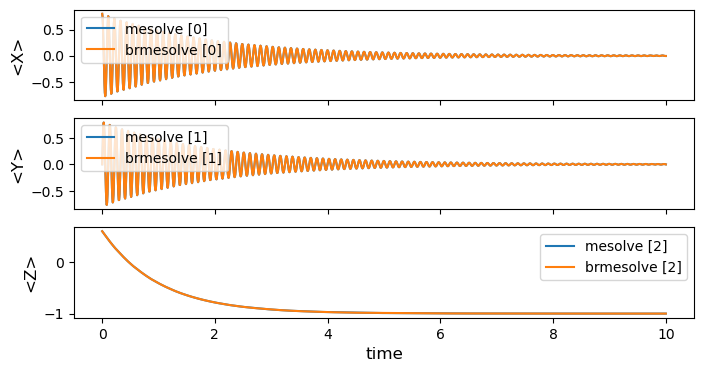

In [253]:
plot_expectation_values(
    [result_me, result_brme], ylabels=["<X>", "<Y>", "<Z>"], show_legend=True
);

#### Plotting this on the Bloch Sphere

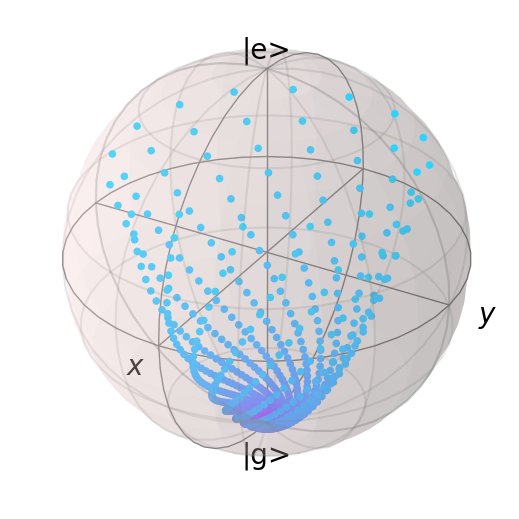

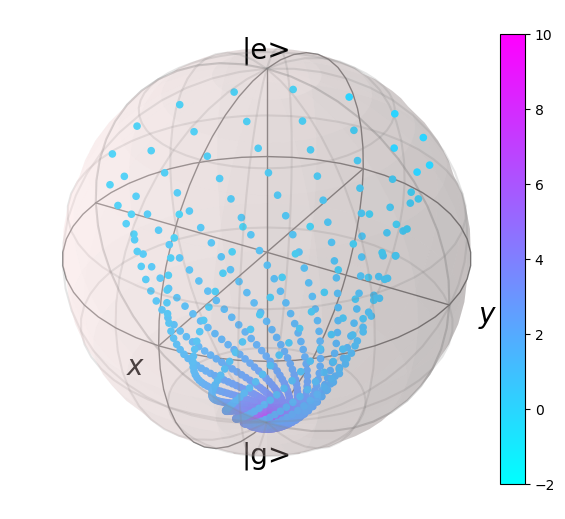

In [254]:
b = Bloch()
# normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(-2, 10)
colors = cm.cool(nrm(times))

# add data points from expectation values ##
b.add_points(result_brme.expect, "m")

# customize sphere properties ##
b.point_color = list(colors)
b.point_marker = ["o"]
b.point_size = [20]
b.zlabel = ['|e>', '|g>']

b.zlpos = [1.1, -1.2]
b.show()
left, bottom, width, height = [0.98, 0.05, 0.05, 0.9]
ax2 = b.fig.add_axes([left, bottom, width, height])
mpl.colorbar.ColorbarBase(ax2, cmap=cm.cool, norm=nrm, orientation="vertical");

b.fig

## Storing States instead of expectation values
As for the other solvers provided in QuTiP, we can obtain the density matrices at each defined time step instead of some expectation values. To do so, we pass an empty list as `e_ops` argument. If you want to calculate expectation values (i.e. non-empty `e_ops`) and obtain the states at the same time you can also pass `options={"store_states": True}` to the solver functions.

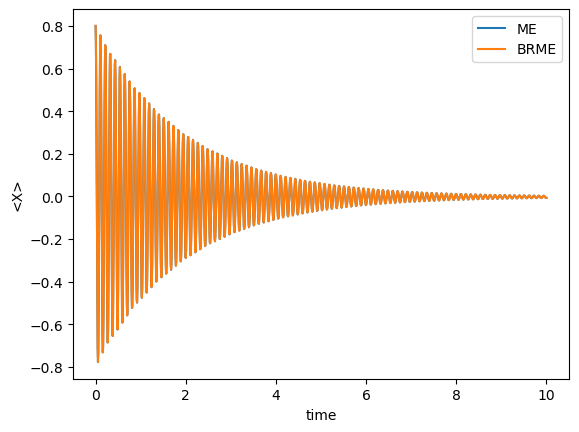

In [255]:
# run solvers without e_ops
me_s = mesolve(H, psi0, times, c_ops, e_ops=[])
brme_s = brmesolve(H, psi0, times, [a_op], e_ops=[])

# calculate expecation values
x_me = expect(sigmax(), me_s.states)
x_brme = expect(sigmax(), brme_s.states)

# plot the expectation values
plt.plot(times, x_me, label="ME")
plt.plot(times, x_brme, label="BRME")
plt.legend(), plt.xlabel("time"), plt.ylabel("<X>");

### Finding the density matrix as a fucntion of time

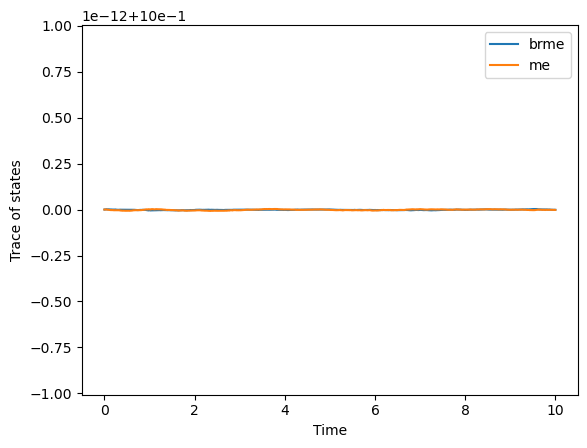

In [256]:
# calculate states for weak coupling
me_states = mesolve(H, psi0, times, c_ops, e_ops=[])
brme_states = brmesolve(H, psi0, times, [a_op], e_ops=[])
# plot the traces and expected trace
plt.plot(times, [state.tr() for state in brme_states.states], label="brme")
plt.plot(times, [state.tr() for state in me_states.states], label="me")
plt.legend(), plt.xlabel("Time"), plt.ylabel("Trace of states");

Can extract the density matrix and use 
$$
\chi(\omega) = \frac{1}{3}|\vec{M}|^2\frac{jN}{\hbar\epsilon_0}\frac{\omega_s}{1/T_2 + j(\omega-\omega_eg)}
$$
Assuming isotropic and homogenous media. To find the susceptability

Where $\vec{M} = e_0<g|\vec{x}|e>$ i.e. the coupling of superposition

In [257]:
M_square = np.abs([state[0][0][1]*state[1][0][0] for state in brme_states.states])

0.15961218222009485 exp(time*  -1.0139288974667469 )


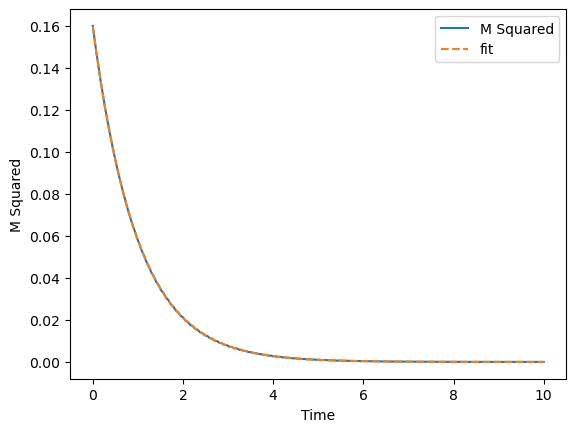

In [258]:
plt.plot(times, M_square, label="M Squared")
# plt.ylim(0,0.2)
A,b = curve_fit(expo,times,M_square)[0]
plt.plot(times, expo(times,A,b), label = "fit", linestyle="dashed")
plt.legend(), plt.xlabel("Time"), plt.ylabel("M Squared");
print(A,"exp(time* ",b,")")

### Plotting imaginary and real $\chi$

For steady state solutions, we can find the imaginary and real parts of $\chi$ as a fucntion of $\omega$ to see how phase shift(Re) and Absoprtion(Im) change with freq.
$$
\chi(\omega) = \chi'(\omega) + \chi''(\omega)
$$
where 
$$
\chi'(\omega) = -\frac{|\vec{M}|^2N\omega_sT_2^2(\omega_{eg}-\omega)}{3\hbar\epsilon_0}L(\omega),
$$
and
$$
\chi''(\omega) = \frac{|\vec{M}|^2N\omega_sT_2}{3\hbar\epsilon_0}L(\omega).
$$
With
$$
L(\omega) = \frac{(1/T_2)^2}{(1/T_2)^2+(\omega_{eg}-\omega)^2},
$$
and
$$
\omega_s = \frac{\omega_0}{1+\frac{I}{I_s}L(\omega)}
$$

Plots below now use the simplified version in Petros' notes

#### Declare const
Using units $\hbar, \epsilon_0, |\vec{M}|^2 = 1$

In [269]:
omega_eg = 10
omega_0 = 1#unsaturated absorption
T_2 = 1
N=1 # nuber density
I = 1
I_s = 1
omega = np.linspace(0,20,100)
detuning = omega-omega_eg

In [270]:
Lorentzian = T_2**-2/(T_2**-2+(omega_eg-omega)**2)
omega_s = omega_0/(1+I/I_s * Lorentzian) #staurated absorbtion
# real_chi1 = -N*omega_s*T_2**2*(omega_eg - omega)*Lorentzian/(3)
# imaginary_chi1 = N*omega_s*T_2*Lorentzian/3

real_chi = -N*Rabi_freq*detuning/(detuning**2+gamma*2/4+Rabi_freq**2/2)
imaginary_chi = N*Rabi_freq*gamma/2/(detuning**2+gamma**2/4+Rabi_freq**2/2)

#### Plot

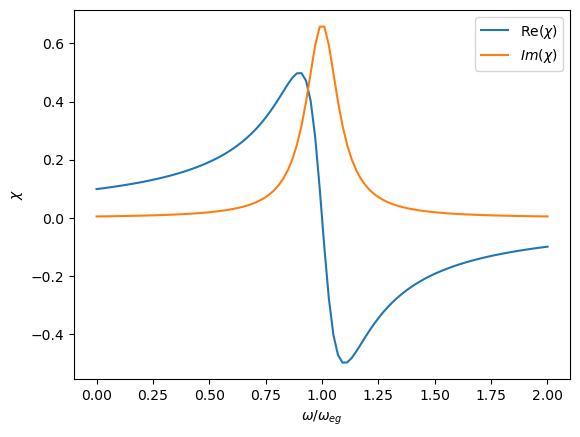

In [271]:
plt.plot(omega/omega_eg,real_chi, label = "Re($\chi$)")
plt.plot(omega/omega_eg,imaginary_chi, label = "$Im(\chi)$")
# plt.plot(omega/omega_eg,np.hypot(real_chi, imaginary_chi), label = "$|\chi|$")
plt.legend(), plt.xlabel("$\omega /\omega_{eg}$"), plt.ylabel("$\chi$");

#### Observations
<!-- $T_2$ transforms as a multiplier on y and divisor on x.<br>
$\omega_{eg}$ translates along x.<br>
$\omega_0$ multiplies y.<br>
$I$ multiplies x and divides y.<br>
$I_s$ multiplies along y.<br> -->


## Bloch-Redfield Tensor

We described the dynmamics of the system by the Bloch-Redfield master equation, which is constructed from the Bloch-Redfield tensor $R_{abcd}$ (see [documentation of Bloch-Redfield master equation](https://qutip.org/docs/latest/guide/dynamics/dynamics-bloch-redfield.html)). Hence the dynamics are determined by this tensor. We can calculate the tensor in QuTiP using the `qutip.bloch_redfield_tensor()` function. We have to pass the Hamiltonian of the system and the dissipation description in `a_ops` to construct $R_{abcd}$. Furthermore, the function gives us the **eigenstates of the Hamiltonian**, as they are calculated along the way.


In [262]:
R, H_ekets = bloch_redfield_tensor(H, [a_op])

# calculate lindblad liouvillian from H
L = liouvillian(H, c_ops)

We can now use the Bloch-Redfield Tensor and the Lindblad Liouvillain to calculate the steadystate for both approaches. As we saw above the dynamics were the same for using the different solvers, hence we expect the steadystate to be equal too. We use the `qutip.hinton()` function to plot the steadystate density matrix for both approaches and can see that they are the same.

We have to transform the steadystate density matrix we obtain from the Bloch-Redfield tensor using the eigenstates of the Hamiltonian, as `R` is expressed in the eigenbasis of `H`.

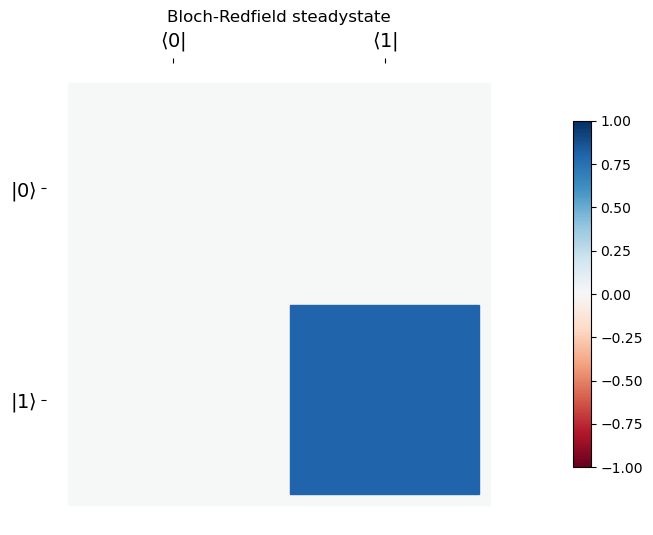

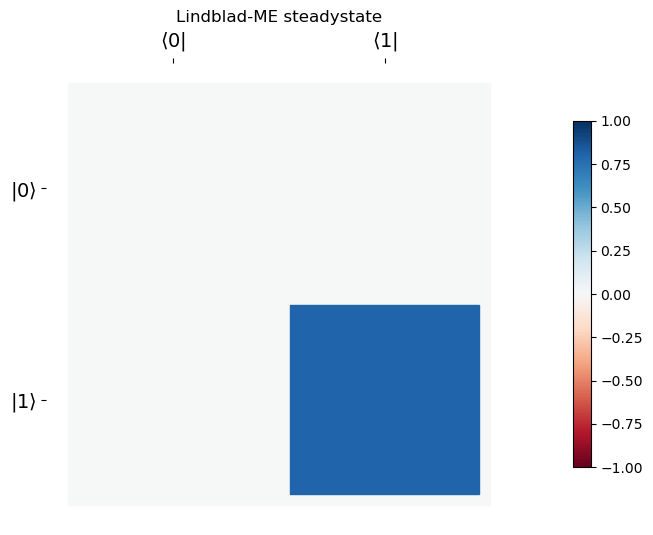

In [121]:
# Obtain steadystate from Bloch-Redfield Tensor
rhoss_br_eigenbasis = steadystate(R)
rhoss_br = rhoss_br_eigenbasis.transform(H_ekets, True)

# Steadystate from Lindblad liouvillian
rhoss_me = steadystate(L)

# Plot the density matrices using a hinton plot
hinton(rhoss_br, title="Bloch-Redfield steadystate")
hinton(rhoss_me, title="Lindblad-ME steadystate");

## About

In [49]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.3
Numpy Version:      1.18.5
Scipy Version:      1.5.0
Cython Version:     0.29.21
Matplotlib Version: 3.2.2
Python Version:     3.8.3
Number of CPUs:     16
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Windows (AMD64)
Installation path:  C:\Users\A_SAU\Anaconda3\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using

## Testing

In [50]:
# Verify that mesolve and brmesolve generate similar results
assert np.allclose(result_me.expect[0], result_brme.expect[0])
assert np.allclose(result_me.expect[1], result_brme.expect[1])
assert np.allclose(result_me.expect[2], result_brme.expect[2])
assert np.allclose(x_me, x_brme)

# assume steadystate is the same
assert np.allclose(rhoss_br, rhoss_me)

https://ocw.mit.edu/courses/6-974-fundamentals-of-photonics-quantum-electronics-spring-2006/2641db6431ea70989c29e8512d5d91a7_chapter6.pdf

In [101]:
result_brme.expect

[array([0.8       , 0.79716046, 0.79398245, ..., 0.00542062, 0.00540614,
        0.00538934]),
 array([ 0.00000000e+00,  1.67089287e-02,  3.32996104e-02, ...,
        -2.28165445e-04, -1.14137798e-04, -8.17270180e-07]),
 array([ 0.6       ,  0.58936184,  0.57879431, ..., -0.99992638,
        -0.99992687, -0.99992736])]

In [3]:
sigmaz()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]